In [1]:
import os
import sys
from tqdm import tqdm

from matplotlib import pyplot as plt ##matplotlib.use('Agg') should call before pyplot for file printing

import tensorflow as tf
import numpy as np

from sklearn import mixture
import math
from tensorflow.python.framework import ops

import glob
import six
# import cPickle
from scipy.ndimage import imread
from scipy.misc import imresize
import scipy.io as sio
from collections import OrderedDict, defaultdict

from scipy import stats

from sklearn.decomposition import PCA

In [2]:
class SynthDataset():   
    def __init__(self, x_dim=100, z_dim=2, num_clusters=10, seed=1234):       
        np.random.seed(seed)
        
        self.x_dim = x_dim
        self.N = 10000
        self.true_z_dim = z_dim
        
        # generate synthetic data
        self.Xs = []
        for _ in range(0,num_clusters):
            cluster_mean = np.random.randn(self.true_z_dim) * 5 # to make them more spread
            A = np.random.randn(self.x_dim, self.true_z_dim) * 5
            X = np.dot(np.random.randn(int(self.N / num_clusters), self.true_z_dim) + cluster_mean, A.T) ##matrix mul
            self.Xs.append(X)
        X_raw = np.concatenate(self.Xs)
        self.X = (X_raw - X_raw.mean(0)) / (X_raw.std(0))
        print ("Dataset shape", self.X.shape)
        
        
    def next_batch(self, batch_size):
        rand_idx = np.random.choice(range(self.N), size=(batch_size,), replace=False)
        return self.X[rand_idx]
    
    def visualize_data(self):
        pca = PCA(n_components=2)
        data = pca.fit_transform(self.X)
        plt.scatter(data[:,0],data[:,1])
        return data

Dataset shape (10000, 100)


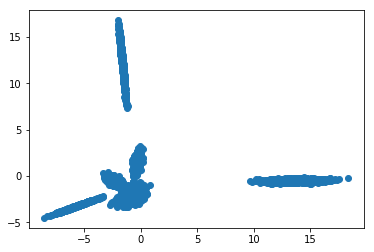

In [3]:
a = SynthDataset()
data = a.visualize_data()

In [4]:
def gmm_ms(X):
    aics = []
    n_components_range = range(1, 20)
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,covariance_type="full")
        gmm.fit(X)
        aics.append(gmm.aic(X))
    return np.array(aics)

def kl_div(p, q):
        eps = 1e-10
        p_safe = np.copy(p)
        p_safe[p_safe < eps] = eps
        q_safe = np.copy(q)
        q_safe[q_safe < eps] = eps
        return np.sum(p_safe * (np.log(p_safe) - np.log(q_safe)))
    
def js_div(p, q):
        m = (p + q) / 2.
        return (kl_div(p, m) + kl_div(q, m))/2.
    
def analyze_div(X_real, X_sample):
    pca = PCA(n_components=2)
    X_trans_real = pca.fit_transform(X_real)
    X_trans_fake = pca.transform(X_sample)
    
    dx = 0.1
    dy = 0.1
    
    xmin1 = np.min(X_trans_real[:, 0]) - 3.0
    xmax1 = np.max(X_trans_real[:, 0]) + 3.0
    
    xmin2 = np.min(X_trans_real[:, 1]) - 3.0
    xmax2 = np.max(X_trans_real[:, 1]) + 3.0
    
    space = np.dstack(np.meshgrid(np.arange(xmin1,xmax1,dx), np.arange(xmin2,xmax2,dy))).reshape(-1, 2).T

    real_kde = stats.gaussian_kde(X_trans_real.T)
    real_density = real_kde(space) * dx * dy

    fake_kde = stats.gaussian_kde(X_trans_fake.T)
    fake_density = fake_kde(space) * dx * dy
    
    return js_div(real_density, fake_density), X_trans_real, X_trans_fake

In [5]:
class BGAN(object):
    def __init__(self, x_dim, z_dim, dataset_size, batch_size=64, prior_std=1.0, J=1, M=50, num_classes=1, alpha=0.01, lr=0.0002,
                 optimizer='adam', ml=False):
        self.batch_size = batch_size
        self.dataset_size = dataset_size
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.optimizer = optimizer
        self.prior_std = prior_std
        self.num_gen = J
        self.num_mcmc = M
        self.alpha = alpha
        self.lr = lr
        self.ml = ml
        if self.ml:
            assert self.num_gen*self.num_mcmc == 1, 'cannot have multiple generators in ml mode'
        self.weight_dims = OrderedDict([('g_h0_lin_w', (self.z_dim, 1000)),('g_h0_lin_b', (1000, )), ('g_lin_w',(1000, self.x_dim)),('g_lin_b',(self.x_dim,))]) ##changed the final x dimension
        self.sghmc_noise = {}
        self.noise_std = np.sqrt(2*self.alpha)
        for name, dim in self.weight_dims.items():
#             self.sghmc_noise[name] = tf.contrib.distributions.Normal(mu=0. , sigma=self.noise_std*tf.ones(self.weight_dims[name])) ##check normal distributions
            self.sghmc_noise[name] = tf.contrib.distributions.Normal(loc=0. , scale=self.noise_std*tf.ones(self.weight_dims[name])) ##check normal distributions

        self.K = num_classes
        self.build_bgan_graph()
        
    def linear(self, input_, output_size, scope=None, matrix=None, bias=None):
        shape = input_.get_shape().as_list()
        with tf.variable_scope(scope or 'Linear'):
            if matrix is None:
                matrix = tf.get_variable("Matrix", [shape[1], output_size], dtype=tf.float32, initializer=tf.random_normal_initializer(stddev=0.02))
            if bias is None:
                bias = tf.get_variable("bias", [output_size], initializer = tf.constant_initializer(0.0))
            return tf.matmul(input_, matrix) + bias
        
    def generator(self, z, gen_params):
        with tf.variable_scope('generator') as scope:
            h = self.linear(z, 1000, 'g_h0_lin', gen_params['g_h0_lin_w'], gen_params['g_h0_lin_b']) ##see when is matrix in linear is created i.e matrix=None
            h0 = tf.maximum(h, 0.2*h)
            self.x_ = self.linear(h0, self.x_dim, 'g_lin', gen_params['g_lin_w'], gen_params['g_lin_b'])
            return self.x_ ##check why its self.x_
        
    def discriminator(self, x, K, reuse=False):
        with tf.variable_scope('discriminator') as scope:
            if reuse:
                scope.reuse_variables()
            h = self.linear(x, 1000, 'd_lin_0')
            h0 = tf.maximum(h, 0.2*h)
            h1 = self.linear(h0, K, 'd_lin_1')
            return tf.nn.softmax(h1), h1 ##check the softmax layer
        
    def sampler(self, z, gen_params): ##why cant use directly
        with tf.variable_scope('generator') as scope:
            scope.reuse_variables()
            return self.generator(z, gen_params)
    
    def gen_prior(self, gen_params): ##why do we want scope here as generator from where dict is coming
        with tf.variable_scope('generator') as scope:
            prior_loss = 0.0
            for var in gen_params.values():
                nn = tf.divide(var, self.prior_std)
                prior_loss += tf.reduce_mean(tf.multiply(nn, nn))
        prior_loss /= self.dataset_size
        return prior_loss
    
    def gen_noise(self, gen_params): #sample ?? 
        with tf.variable_scope('generator') as scope:
            noise_loss = 0.0
            for name, var in gen_params.items():
                noise_loss += tf.reduce_sum(var * self.sghmc_noise[name].sample())
        noise_loss /= self.dataset_size
        return noise_loss
    
    def disc_prior(self):## why using self.d_vars
        with tf.variable_scope('discriminator') as scope:
            prior_loss = 0.0
            for var in self.d_vars:
                nn = tf.divide(var, self.prior_std)
                prior_loss += tf.reduce_mean(tf.multiply(nn, nn))
        prior_loss /= self.dataset_size
        return prior_loss
    
    def disc_noise(self): ## sample ? 
        with tf.variable_scope('discriminator') as scope:
            noise_loss = 0.0
            for var in self.d_vars:
#                 noise_ = tf.contrib.distributions.Normal(mu=0.0, sigma=self.noise_std*tf.ones(var.get_shape()))
                noise_ = tf.contrib.distributions.Normal(loc=0.0, scale=self.noise_std*tf.ones(var.get_shape()))
                noise_loss += tf.reduce_sum(var * noise_.sample())
        noise_loss /= self.dataset_size
        return noise_loss

    
    def build_bgan_graph(self):
        self.inputs = tf.placeholder(tf.float32, shape=(self.batch_size,self.x_dim), name = 'real_images') ##check why addition of x_dim
        self.labels = tf.placeholder(tf.float32, shape=(self.batch_size,self.K+1), name='real_targets')
        self.z = tf.placeholder(tf.float32, shape=(None, self.z_dim), name='z')
        
        self.gen_param_list = []
        with tf.variable_scope('generator') as scope:
            for g in range(self.num_gen):
                for m in range(self.num_mcmc):
                    gen_params = {}  ##check with attributedict method in code
                    for name, shape in self.weight_dims.items():
                        gen_params[name] = tf.get_variable("%s_%04d_%04d" % (name, g, m), shape, initializer=tf.random_normal_initializer(stddev=0.02))
                    self.gen_param_list.append(gen_params)
                    
        self.D, self.D_logits = self.discriminator(self.inputs, self.K+1) ##loading real data
        
        constant_labels = np.zeros((self.batch_size, 2)) ##why labels are two size
        constant_labels[:, 1] = 1.0
        self.d_loss_real = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.D_logits,labels=tf.constant(constant_labels))) ##check loss function
        
        self.generation = defaultdict(list)
        for gen_params in self.gen_param_list:
            self.generation['g_prior'].append(self.gen_prior(gen_params))
            self.generation['g_noise'].append(self.gen_noise(gen_params))
            self.generation['generators'].append(self.generator(self.z, gen_params))
            self.generation['gen_samplers'].append(self.sampler(self.z, gen_params))
            D_, D_logits = self.discriminator(self.generator(self.z, gen_params), self.K+1, reuse=True) ##why calling generator again
            self.generation['d_logits'].append(D_logits)
            self.generation['d_probs'].append(D_)
            
        d_loss_fakes = []
        constant_labels = np.zeros((self.batch_size, self.K+1))
        constant_labels[:,0] = 1.0
        for logits in self.generation['d_logits']:
            d_loss_fakes.append(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=tf.constant(constant_labels)))) ##check why it is not stored in self as like self.d_loss_real
            
        t_vars = tf.trainable_variables()
        self.d_vars = [var for var in t_vars if 'd_' in var.name] ##check this d_
        
        d_losses = []
        for d_loss_fake_ in d_loss_fakes:
            d_loss_ = self.d_loss_real + d_loss_fake_
            if not self.ml: ##why is this ml for
                d_loss_ += self.disc_prior()+self.disc_noise()
            d_losses.append(tf.reshape(d_loss_, [1])) ##check reshpae
        self.d_loss = tf.reduce_logsumexp(tf.concat(d_losses,0)) ## why logsumexp and concat ##1.4version axis=0 no concat
        
        self.g_vars = []
        for g in range(self.num_gen):
            for m in range(self.num_mcmc):
                self.g_vars.append([var for var in t_vars if 'g_' in var.name and "_%04d_%04d" % (g, m) in var.name])
        
        
        self.d_learning_rate = tf.placeholder(tf.float32, shape=[])
        d_opt = tf.train.AdamOptimizer(learning_rate=self.d_learning_rate, beta1=0.5)
        self.d_optim = d_opt.minimize(self.d_loss, var_list=self.d_vars) ##skipped d_optim_adam in code
        
        self.g_optims = []
        self.g_learning_rate = tf.placeholder(tf.float32, shape=[])
        for g in range(self.num_gen * self.num_mcmc):
            g_loss = -tf.reduce_mean(tf.log((1.0 - self.generation['d_probs'][g][:,0]) + 1e-8))
            if not self.ml:
                g_loss += self.generation['g_prior'][g] + self.generation['g_noise'][g]
            self.generation['g_losses'].append(g_loss)
            g_opt = tf.train.AdamOptimizer(learning_rate=self.g_learning_rate, beta1=0.5)
            self.g_optims.append(g_opt.minimize(g_loss, var_list = self.g_vars[g]))

In [6]:
def get_session(): ##understand sessions in tf
    global _SESSION
    if tf.get_default_session() is None:  
        _SESSION = tf.InteractiveSession()
    else:
        _SESSION = tf.get_default_session()

    return _SESSION

In [7]:
batch_size = 64
iterations = 240
z_dim = 10
lr_decay = 3.
base_lr = 1e-2
num_generators = 5
mcmc_samples = 100
results_path = './results/'
if not os.path.exists(results_path):
    os.makedirs(results_path)

In [ ]:
syn_data = SynthDataset()
aics = gmm_ms(syn_data.X)    
print("Number of clusters in the data (AIC Estimate):", aics.argmin())
bgan = BGAN(x_dim=syn_data.x_dim, z_dim=z_dim, dataset_size=syn_data.N, J=num_generators, M=mcmc_samples)
print("Starting session")
# tf.reset_default_graph()
session = get_session()
tf.global_variables_initializer().run()
print("Starting training loop")
sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
all_data_fake = []
all_aics_fake = []
all_div = []
dis_loss = []
gen_loss = defaultdict(list)

Dataset shape (10000, 100)
Number of clusters in the data (AIC Estimate): 10


In [ ]:
print("Iteration starts")
# for iteration in tqdm(range(0,iterations)):
for iteration in range(0,iterations):
    learning_rate = base_lr * np.exp(-lr_decay * min(1.0, (iteration*batch_size)/float(syn_data.N)))
    batch_z = np.random.uniform(-1, 1, [batch_size, z_dim])
    input_batch = syn_data.next_batch(batch_size)
    _, d_loss = session.run([bgan.d_optim, bgan.d_loss], feed_dict={bgan.inputs: input_batch, bgan.z: batch_z, bgan.d_learning_rate: learning_rate})

    g_losses = []
    for g in range(0, bgan.num_gen): # compute g_sample loss
        batch_z = np.random.uniform(-1, 1, [batch_size, z_dim]) ## redundant
        _, g_loss = session.run([bgan.g_optims[g], bgan.generation["g_losses"][g]], feed_dict={bgan.z: batch_z, bgan.g_learning_rate: learning_rate})
        g_losses.append(g_loss)
        
#     print("Disc loss = %.2f" % d_loss, ", Gen loss = ", ", ".join(["%.2f" % gl for gl in g_losses])) 
    dis_loss.append(d_loss)
    for i,loss in enumerate(g_losses, start=1):
        gen_loss[i].append(loss)

    if (iteration + 1) % 10 == 0:
        labels = []
        plt.figure(figsize=(5,3))
        plt.title('Loss_curve')
        plt.xlabel('Iterations')
        plt.plot(dis_loss)
        labels.append('Dis-loss')
        for key,value in gen_loss.items():
            plt.plot(value)
            labels.append('Gen'+str(key)+'-loss')
        plt.legend(labels, loc='upper left')
        plt.show()
        
        print("Running GMM on sample data")
        fake_data = [] ##generating data from the distribution
        for num_samples in range(0, 10):
            for g in range(0, bgan.num_gen):
                # collect sample
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) ## redundant
                sampled_data = session.run(bgan.generation["gen_samplers"][g], feed_dict={bgan.z: sample_z})
                fake_data.append(sampled_data)
                
        X_real = syn_data.X
        X_sample = np.concatenate(fake_data) ##why np.concatenate
        all_data_fake.append(X_sample)
        
        aics_fake = gmm_ms(X_sample)
        all_aics_fake.append(aics_fake)
        print("Fake number of clusters (AIC Estimate):", aics_fake.argmin())
        
        div, X_trans_real, X_trans_fake = analyze_div(X_real, X_sample)
        all_div.append(div)
        print("JS div", div) 
        
        plt.figure(figsize=(5,3))
        plt.title('JS Div')
        plt.xlabel('Iterations')
        plt.plot(all_div)
        plt.show()
        
        fig, ax_arr = plt.subplots(1,2)
        xmin1 = np.min(X_trans_real[:, 0]) - 1.0
        xmax1 = np.max(X_trans_real[:, 0]) + 1.0
        xmin2 = np.min(X_trans_real[:, 1]) - 1.0
        xmax2 = np.max(X_trans_real[:, 1]) + 1.0
        ax_arr[0].plot(X_trans_real[:, 0], X_trans_real[:, 1], '.r')
        ax_arr[0].set_xlim([xmin1, xmax1]); ax_arr[0].set_ylim([xmin2, xmax2])
        ax_arr[1].plot(X_trans_fake[:, 0], X_trans_fake[:, 1], '.g')
        ax_arr[1].set_xlim([xmin1, xmax1]); ax_arr[1].set_ylim([xmin2, xmax2])
        ax_arr[0].set_aspect('equal', adjustable='box')
        ax_arr[1].set_aspect('equal', adjustable='box')
        ax_arr[0].set_title("Iteration %i" % (iteration+1))
        ax_arr[1].set_title("Iteration %i" % (iteration+1))
        plt.show()
        save_weights=True
        if save_weights:
            var_dict = {}
            for var in tf.trainable_variables():
                var_dict[var.name] = session.run(var.name)
            np.savez_compressed(os.path.join(results_path, "weights_%i.npz" % iteration),**var_dict)

In [ ]:
# cluster_mean = np.random.randn(2) * 5 # to make them more spread
# print(cluster_mean)
# A = np.random.randn(100, 2) * 5
# print(A.shape)
# b = A + cluster_mean
# print(b.shape)
# X = np.dot(np.random.randn(1000, 2) + cluster_mean, A.T)##1000 points in cluster
# print(X.shape)